# Project 4 - Monreader

**Introduction:**

MonReader is a new mobile document digitization experience for the blind, for researchers and for everyone else in need for fully automatic, highly fast and high-quality document scanning in bulk. It is composed of a mobile app and all the user needs to do is flip pages and everything is handled by MonReader: it detects page flips from low-resolution camera preview and takes a high-resolution picture of the document, recognizing its corners and crops it accordingly, and it dewarps the cropped document to obtain a bird's eye view, sharpens the contrast between the text and the background and finally recognizes the text with formatting kept intact, being further corrected by MonReader's ML powered redactor.

**Data Description:**

Data consiste of page flipping videos from smart phones. These are labelled as flipping and not flipping. These were posteriorly clipped as short videos and again labelled as flipping or not flipping. The extracted frames were then saved to disk in a sequential order with the following naming structure: VideoID_FrameNumber

**Goal(s):**

Predict if the page is being flipped using a single image.

**Success Metrics:**

Evaluate model performance based on F1 score, the higher the better.

**Bonus(es):**

Predict if a given sequence of images contains an action of flipping.

**Conclusion**

An F1 score of 68.42% was obtained using a custom test dataset.

In [1]:
from __future__ import print_function, division
import os
import pandas as pd
import numpy as np
import sys

sys.path.append('../')


import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torchvision.models import resnet18, ResNet18_Weights, vgg11, VGG11_Weights, vgg16, VGG16_Weights, AlexNet, AlexNet_Weights
import matplotlib.pyplot as plt
import time
import os
import copy
from torch.utils.data import DataLoader, ConcatDataset
import torch.optim as optim
import gc

# del variables
# gc.collect()
torch.cuda.empty_cache()

cudnn.benchmark = True
plt.ion()   # interactive mode

In [2]:
%load_ext autoreload
# %reload_ext autoreload
%autoreload 2

## Get images

In [3]:
from utils import imshow, train, get_classification_report, save_model

DATA_PATH = 'images'
DATASET_CSV_PATH = 'datasets'

BATCH_SIZE = 64
NUM_WORKERS = 2

In [4]:
# Data augmentation and normalization for training
# Just normalization for validation
# python image library of range [0, 1], transform them to tensors of normalized range[-1, 1]
torch.manual_seed(42)

data_transforms = {
    'train': transforms.Compose([
        transforms.CenterCrop((900, 900)),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]),
    'val': transforms.Compose([
        transforms.CenterCrop((900, 900)),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]),
}

image_datasets = {x: datasets.ImageFolder(os.path.join(DATA_PATH, x), data_transforms[x])
                  for x in ['train', 'val']}

dataloaders = {x: DataLoader(image_datasets[x], batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
              for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = "cpu"

# print(image_datasets)
print('split\t', dataset_sizes, '\nclasses\t', class_names, '\ndevice\t', device)

split	 {'train': 2392, 'val': 597} 
classes	 ['flip', 'notflip'] 
device	 cuda:0


Image batch shape: torch.Size([64, 3, 224, 224])
Labels batch shape: torch.Size([64])


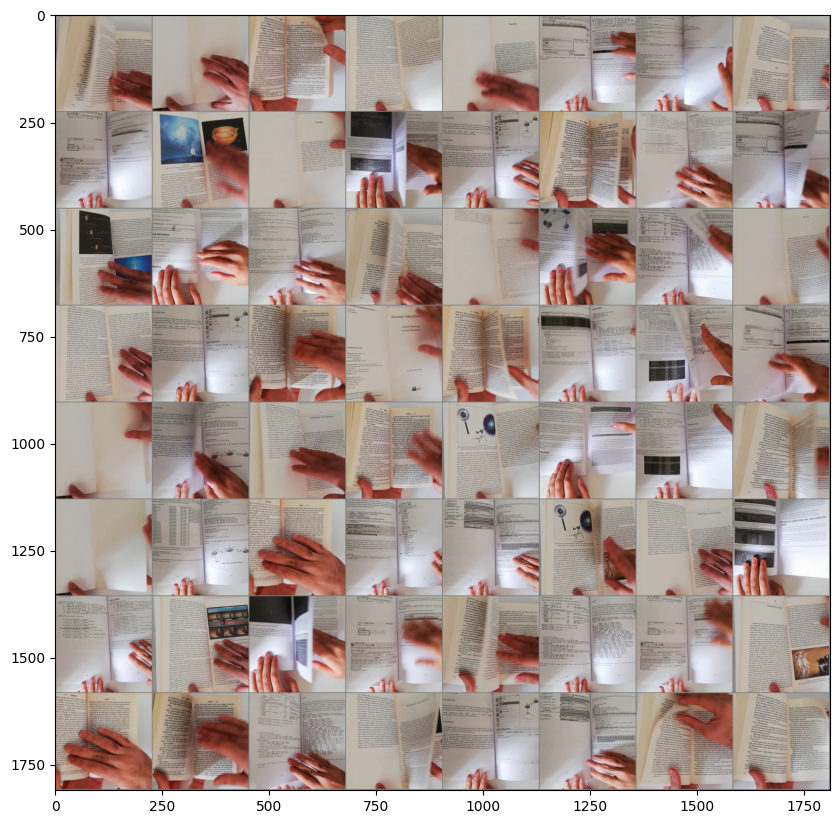

flip notflip flip flip notflip notflip flip notflip flip notflip notflip flip notflip flip flip flip flip notflip notflip flip notflip flip flip flip notflip notflip flip notflip flip notflip flip flip notflip flip flip flip flip notflip flip flip flip notflip notflip notflip notflip flip notflip flip notflip notflip flip notflip flip notflip notflip notflip notflip flip flip flip notflip notflip flip flip


In [5]:
# Display image and label.
train_images, train_labels = next(iter(dataloaders['train']))
print(f"Image batch shape: {train_images.size()}")
print(f"Labels batch shape: {train_labels.size()}")

# We are going to visualize the same amount of images as our batch size
imshow(torchvision.utils.make_grid(train_images), class_names, train_labels)
print(' '.join('%s' % class_names[train_labels[j]] for j in range(BATCH_SIZE)))

In [27]:
net = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
num_ftrs = net.fc.in_features
# num_ftrs = len(net.features)
print((num_ftrs))
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
net.fc = nn.Linear(num_ftrs, 2)

net = net.to(device)

512


In [29]:
LR = 0.001
EPOCH = 3

criterion = nn.CrossEntropyLoss() # Classification problem
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
# optimizer = optim.Adam(net.parameters(), lr=LR)
epoch, loss = train(bs=BATCH_SIZE, epochs=EPOCH, train_loader=dataloaders['train'], opt=optimizer, model=net, criterion=criterion, device=device)
save_model(model=net, epoch=epoch, loss=loss, path='model_p4.pt', optimizer=optimizer)

[EPOCH:1, BATCH:   38] loss: 0.051
[EPOCH:2, BATCH:   38] loss: 0.039
[EPOCH:3, BATCH:   38] loss: 0.038
Finished Training


In [30]:
print('TRAIN')
get_classification_report(net, dataloaders['train'], device)

TRAIN
              precision    recall  f1-score   support

           0       0.68      0.73      0.70        26
           1       0.81      0.76      0.78        38

    accuracy                           0.75        64
   macro avg       0.74      0.75      0.74        64
weighted avg       0.75      0.75      0.75        64

F1 score:  78.38
Confusion matrix:
 [[19  7]
 [ 9 29]]


In [31]:
net = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
# num_ftrs = len(net.features)
num_ftrs = net.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
net.fc = nn.Linear(num_ftrs, 2)

net = net.to(device)

params = list(net.parameters())
checkpoint = torch.load('model_p4.pt')
net.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

net.eval();

In [52]:
torch.manual_seed(42)
test_data_transforms = transforms.Compose([
        transforms.CenterCrop((300, 300)),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

test_dataset = datasets.ImageFolder(os.path.join(DATA_PATH, 'final'), test_data_transforms)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True, num_workers=4)

test_dataset_size = len(test_dataset)
test_class_names = test_dataset.classes

# print(image_datasets)
print('size:\t', test_dataset_size, '\nclasses\t', test_class_names, '\n', device)

size:	 3331 
classes	 ['flip', 'no flip'] 
 cuda:0


Images batch shape: torch.Size([64, 3, 224, 224])
Labels batch shape: torch.Size([64])


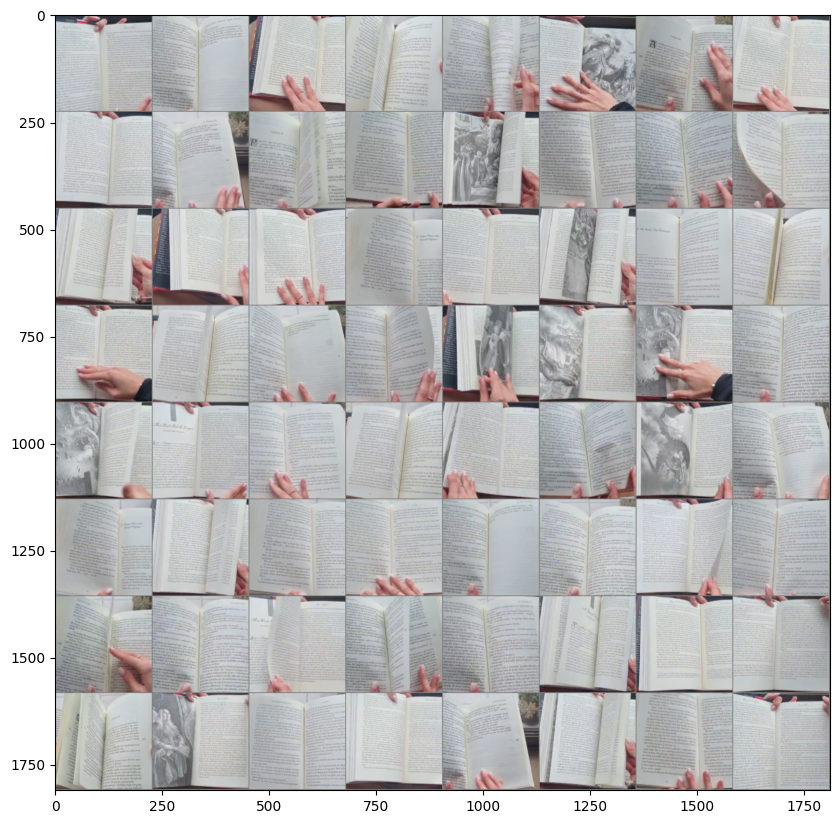

notflip notflip notflip flip flip notflip notflip notflip notflip notflip flip notflip flip notflip notflip flip flip notflip notflip notflip notflip flip flip flip notflip flip flip flip flip notflip notflip notflip flip notflip notflip flip notflip flip flip notflip notflip flip notflip notflip notflip notflip flip notflip flip notflip flip flip notflip flip notflip notflip flip notflip notflip notflip notflip flip notflip notflip


In [53]:
# Display image and label.
test_images, test_labels = next(iter(test_dataloader))
print(f"Images batch shape: {test_images.size()}")
print(f"Labels batch shape: {test_labels.size()}")

# We are going to visualize the same amount of images as our batch size
imshow(torchvision.utils.make_grid(test_images), class_names, test_labels)
print(' '.join('%s' % class_names[test_labels[j]] for j in range(BATCH_SIZE)))


TEST
              precision    recall  f1-score   support

           0       0.41      0.78      0.54        18
           1       0.87      0.57      0.68        46

    accuracy                           0.62        64
   macro avg       0.64      0.67      0.61        64
weighted avg       0.74      0.62      0.64        64

F1 score:  68.42
Confusion matrix:


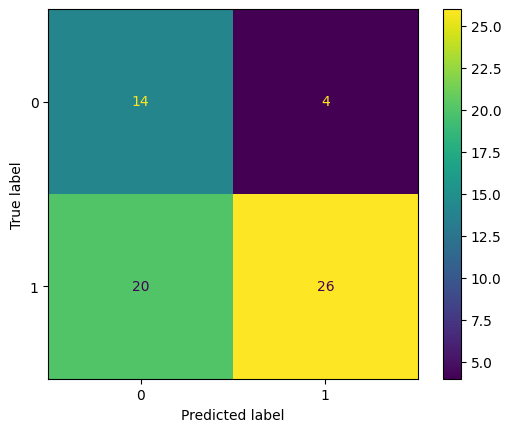

In [55]:
print('\nTEST')
get_classification_report(net, test_dataloader, device)

## Conclusion

An F1 score of 68.42% was obtained using a custom test dataset.

The training and validation dataset were processed using a 900x900 center crop to eliminate unnecesary noise and focus on the center of the book where more flip information is stored. After applying this, the images were resized to 224x224 and normalized.

A custom test dataset was generated were the images were also processed using a 300x300 center crop, a final resize to 224x224 and normalization.